# Step 1: Load Networks

for backprop, keeping 66% of networks
for backprop_nd, keeping 90% of networks
for gating, keeping 100% of networks
for strong_attractor, keeping 100% of networks
for reshuffle, keeping 96% of networks
for inversion, keeping 100% of networks
for gating+reshuffle, keeping 86% of networks
for gating+inversion, keeping 100% of networks


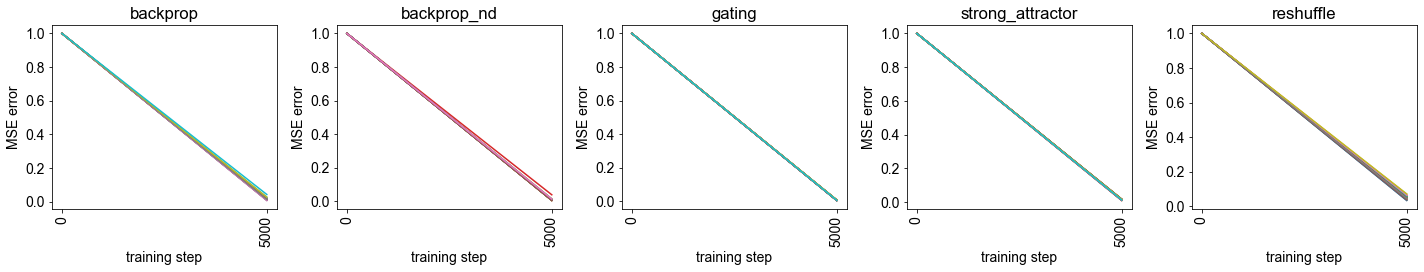

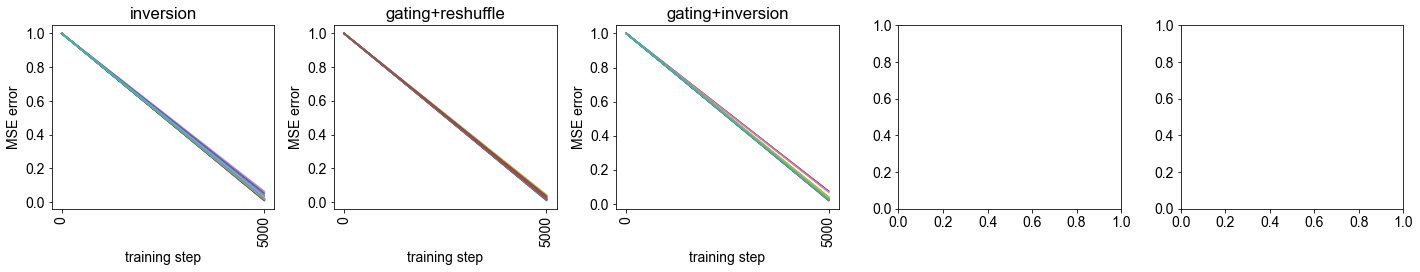

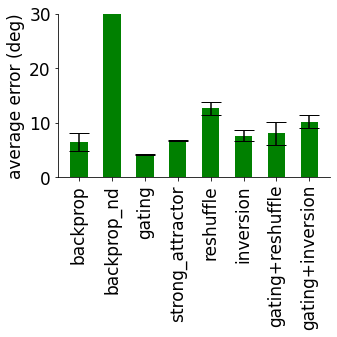

In [196]:
import numpy as np
import os
from netrep.metrics import LinearMetric
from netrep.metrics import GaussianStochasticMetric
import matplotlib.pyplot as plt
import seaborn as sns
import json, math
from scipy import stats
import torch

neuraldata_normalization = "zscore"  # zscore, range, None
neuraldata_set = "either_selective"  # either_selective, both_selective
rnn_normalization = "zscore"  # zscore, range, None
rnn_add_sensory_units = True  # whether to add the sensory units of the RNNs into the procrustes distance calculation

neuraldata_normalization_suffix = {"zscore": "_zscored", None: "", "range": ""}[neuraldata_normalization]

# Load all networks to study here
n_networks = 30
net_size = 100
all_networks = {
    "backprop": {
        "color": "#000000", # color of dots on the graph
        "names": [f"data/backpropCTRNN_2DIR1O_dr{net_size}_n0.1_la0_e1_dp1.0_r{i}" for i in range(n_networks)], # directories
        "indices": np.arange(0, 64, 16), # indices of trials to consider (here, only using 4 trials to match neural data)
        "display_name": "Trained"
    },
    "backprop_nd": {
        "color": "gray",
        "names": [f"data/backpropCTRNN_2DIR1O_dr{net_size}_n0.1_la0_e1_dp0.0_r{i}" for i in range(n_networks)],
        "indices": np.arange(0, 64, 16),
        "display_name": "WM only"
    },
    "gating": {
        "color": "#B41F24",  # color of dots on the graph
        "names": [f"data/hdgatingCTRNN_2DIR1O_dr{net_size}_n0.1_la0_e1_dp1.0_r{i}" for i in range(n_networks)],  # directories
        "indices": np.arange(0, 64, 16),
        "display_name": "G"
    },
    "strong_attractor": {
        "color": "#009444",  # random color
        "names": [f"data/hdratioCTRNN_2DIR1O_dr{net_size}_n0.1_la0_e1_dp1.0_r{i}" for i in range(n_networks)],
        "indices": np.arange(0, 64, 16),
        "display_name": "SA"
    },
    "reshuffle": {
        "color": "#B3A032",
        "names": [f"data/hdreshuffle_fCTRNN_2DIR1O_dr{net_size}_n0.1_la0_sa130_e1_dp1.0_r{i}" for i in range(n_networks)],
        "indices": np.arange(0, 64, 16),
        "display_name": "R/T"
    },
    "inversion": {
        "color": "#3E4D99",
        "names": [f"data/hdinversionCTRNN_2DIR1O_dr{net_size}_n0.1_la0_e1_dp1.0_r{i}" for i in range(n_networks)],
        "indices": np.arange(0, 64, 16),
        "display_name": "I/T"
    },
    "gating+reshuffle": {
        "color": "#9A583F",
        "names": [f"data/hdgating_and_reshuffle_fCTRNN_2DIR1O_dr{net_size}_n0.1_la0_sa130_e1_dp1.0_r{i}" for i in range(n_networks)],
        "indices": np.arange(0, 64, 16),
        "display_name": "G+R/T"
    },
    "gating+inversion": {
        "color": "#9A3E84",
        "names": [f"data/hdgating_and_inversionCTRNN_2DIR1O_dr{net_size}_n0.1_la0_e1_dp1.0_r{i}" for i in range(n_networks)],
        "indices": np.arange(0, 64, 16),
        "display_name": "G+I/T"
    },
    "mendoza_halliday_et_al_2014": {
        "color": "#F15A29",
        "names": [f"neuraldata/new/diego_phd_mst_{neuraldata_set}{neuraldata_normalization_suffix}"],
        "indices": np.array([0, 1, 2, 3]),
        "neural": True,
        "display_name": "MST1"
    },
    "mendoza_halliday_et_al_2023": {
        "color": "#F15A29",
        "names": [f"neuraldata/new/diego_new_mst_{neuraldata_set}{neuraldata_normalization_suffix}"],
        "indices": np.array([0, 1, 2, 3]),
        "neural": True,
        "display_name": "MST2"
    }
}


# load information about every network
for network in list(all_networks.values()):
    if "neural" in network: continue
    network["errors"] = []
    network["metadatas"] = []
    indices_to_remove = []
    for i, name in enumerate(network["names"]):
        if not os.path.isfile(name+"/info.json"):
            print("FILE DOES NOT EXIST:", name)
            indices_to_remove.append(i)
            continue
        with open(name+"/info.json") as f: info = json.load(f)
        network["errors"].append((info["error_distractor"][2], info["error_nodistractor"][2]))
        network["metadatas"].append(info)
    for x in indices_to_remove[::-1]:
        del network['names'][x]
    

# filter to only use the networks where MSE < 15 deg (only those that converged)
for name, network in all_networks.items():
    if 'errors' in network:
        indices_to_remove = []
        for i, error in enumerate(network['errors']):
            if (name == "backprop_nd" and (error[1]>15 or math.isnan(error[1]))) or ((error[0]>15 or math.isnan(error[0])) and name !="backprop_nd"):
                indices_to_remove.append(i)
                
        print(f"for {name}, keeping {int((1-len(indices_to_remove)/len(network['names']))*100)}% of networks")
        for x in indices_to_remove[::-1]:
            del network['names'][x]
            del network['errors'][x]
            del network['metadatas'][x]

# show all errors through time, for an overview
row_count = 0  # Counter to track the number of plots in the current row
fig, axs = plt.subplots(1, 5, figsize=(20, 4))  # Create a row of 5 subplots
for network_name, network in all_networks.items():
    if "neural" in network: continue
    ax = axs[row_count]  # Select the subplot
    for name in network["names"]:
        with open(name+"/info.json") as f: 
            info = json.load(f)
        ax.plot(list(info["error_store_saved"].keys()), list(info["error_store_saved"].values()))
    ax.set_title(network_name)
    ax.set_xlabel("training step")
    ax.set_ylabel("MSE error")
    for label in ax.get_xticklabels(): label.set_rotation(90)
    row_count += 1
    if row_count >= 5:  # Reset if 5 plots in a row
        plt.tight_layout()
        plt.show()
        fig, axs = plt.subplots(1, 5, figsize=(20, 4))
        row_count = 0
plt.tight_layout()
plt.show()

# show all final errors of kept networks, for comparison
use_networks = [key for key in all_networks.keys() if "neural" not in all_networks[key] or not all_networks[key]["neural"]]
means = [np.mean(np.array(all_networks[network]["errors"])[:, 0]) for network in use_networks]
errors = [np.std(np.array(all_networks[network]["errors"])[:, 0]) for network in use_networks]
fig = plt.figure(figsize=(5, 5))
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 17})
ax = plt.subplot(1, 1, 1)
ax.bar(np.arange(1, len(use_networks)+1)*1.5, means, yerr=errors, align='center', alpha=1, ecolor='black', capsize=10, color="green")
plt.xticks(ticks=np.arange(1, len(use_networks)+1)*1.5, labels=use_networks)
plt.ylim(0, 30)
ax.set_ylabel('average error (deg)')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()

# for rnn_add_sensory_units
def _o_spikes(pref, stim, exponent, max_spike, k):
    # o_spikes: spike numbers per trial for direction tuning cells
    # r = o_spikes(pref, stim, exponent, k)
    # pref: row vec for cells' preferred directions
    # stim: column vec for stimulus directions
    # exponent: scalar determining the widths of tuning. larger value for sharper tuning
    # maxSpike: scalar for mean max spike number when pref = stim
    # k: scalar for determining variance = k * mean
    # spikes: different columuns for cells with different pref orintations
    #         different rows for different stim directions
    np_ = pref.shape[0]  # number of elements in pref
    ns = stim.shape[0]  # number of elements in stim
    prefs = torch.ones((ns, 1)) @ pref[None, :]  # ns x np array, (ns x 1) @ (1 x np)
    stims = stim[:, None] @ torch.ones((1, np_))  # ns x np array, (ns x 1) @ (1 x np)
    # mean spike numbers
    mean_spike = max_spike * (0.5 * (torch.cos( (prefs - stims)) + 1)) ** exponent  # ns x np array
    # sigma for noise
    sigma_spike = torch.sqrt(k * mean_spike)
    # spikes = normrnd(meanSpike, sigmaSpike)# ns x np array, matlab
    spikes = torch.normal(mean_spike, sigma_spike)  # ns x np array, python
    # no negative spike numbers
    spikes[spikes < 0] = 0  # ns x np array
    return spikes
def _input_direction_representation(direction):
    # convert input direction angle (in deg) to firing rates of direction-selective input units
    pref = 2*math.pi * torch.arange(net_size) / net_size
    stim = torch.tensor([(direction / 180 * math.pi)], dtype=torch.float32)
    exponent = 4; max_spike = 1; k = 0
    rates = _o_spikes(pref, stim, exponent, max_spike, k)[0]
    return rates

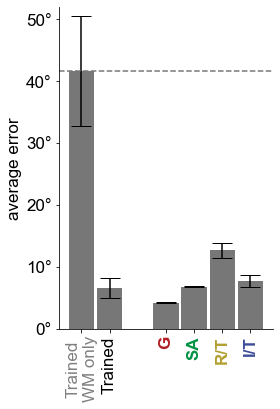

In [197]:
from matplotlib.ticker import FormatStrFormatter
# show all final errors of kept networks, for comparison
x_values = [1, 2, 4, 5, 6, 7]
use_networks = ['backprop_nd', 'backprop', 'gating', 'strong_attractor', 'reshuffle', 'inversion']
network_names = [all_networks[x]['display_name'] for x in use_networks]
network_colors = [all_networks[x]['color'] for x in use_networks]
#network_colors[0] = network_colors[1]
network_names[1] = "Trained"
network_names[0] = "Trained\nWM only"
#network_colors = ['black' for x in use_networks]
barcolor = "#777"

#use_networks = ['backprop', None, 'gating', 'ratio', 'reshuffle_ad', 'inversion']
means = [np.mean(np.array(all_networks[network]["errors"])[:, 0]) for network in use_networks]
errors = [np.std(np.array(all_networks[network]["errors"])[:, 0]) for network in use_networks]

fig = plt.figure(figsize=(4.2, 6))
plt.rc('font', **{'family': 'Arial', 'weight': 'normal', 'size': 17})
ax = plt.subplot(1, 1, 1)
ax.axhline(means[0], 0, 100, color=barcolor, alpha=1, linestyle="--")
ax.bar(x_values, means, yerr=errors, align='center', width=.9, alpha=1, ecolor='black', capsize=10, color=barcolor)
plt.xticks(ticks=x_values, labels=network_names)
plt.ylim(0, 52)
ax.set_ylabel('average error')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().set_xticklabels(ax.get_xticklabels(), rotation=90)
# Loop through the tick labels and set their colors
for i, ticklabel in enumerate(ax.get_xticklabels()):
    ticklabel.set_color(network_colors[i])
    if i>1: ticklabel.set_weight('bold')
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%d°'))
plt.tight_layout()
#plt.savefig('paper_figures/_solutions_errors.pdf', bbox_inches='tight')

In [198]:
def smooth_zscore_normalization(firing_rates, smoothing_term=0.01):
    mean_fr = np.expand_dims(np.mean(firing_rates, axis=0), axis=0)
    std_fr = np.expand_dims(np.std(firing_rates, axis=0), axis=0)
    return (firing_rates - mean_fr)/(std_fr+smoothing_term)

def smooth_range_normalization(firing_rates, smoothing_term=0.01):
    min_fr = np.expand_dims(np.min(firing_rates, axis=0), axis=0)
    max_fr = np.expand_dims(np.max(firing_rates, axis=0), axis=0)
    return (firing_rates-min_fr) / (max_fr-min_fr+smoothing_term)    
    
arrays = []
network_names = []
i = 0
for network_name, network in all_networks.items():
    names = network["names"]
    if "neural" in network:  # process neural data separately, as it's in a different format.
        for name in names:
            temp = np.load(name+".npy").reshape(4, 2, -1)
            if neuraldata_normalization == "range":
                temp = smooth_range_normalization(temp, smoothing_term=0.01)
            temp = temp.reshape(-1, temp.shape[-1])
            arrays.append(temp)
            print(temp.shape)
    else:
        for j, name in enumerate(names):
            # defining parameters (these have to be the same as in training files)
            n_trials = 64

            model_parameterupdate = network['metadatas'][j]['hyperparameters']['train_for_steps']
            task_param = network['metadatas'][j]['task_parameters']
            delay0 = (task_param['delay0_from']+task_param['delay0_to'])//2
            delay1 = task_param['delay1_to']
            delay2 = (task_param['delay2_from']+task_param['delay2_to'])//2
            input_time = task_param['show_direction_for']
            show_cue_for = task_param['show_cue_for']
            net_size = network['metadatas'][j]['model_parameters']['dim_recurrent']
            
            total_time = delay0+delay2+input_time+show_cue_for
            t_cue_from = delay0
            t_cue_to = delay0+input_time
            t_d_from = delay0+input_time+20  # remove first 200 ms of delay (as in neural data)
            t_d_to = delay0+input_time+delay1

            array = np.load(name+f"/model_parameterupdate{model_parameterupdate}_fr.npy")
            temp = np.zeros((n_trials, 2, net_size))
            temp[:, 0, :] = np.mean(array.reshape(n_trials, total_time, net_size)[::, t_cue_from:t_cue_to, :], axis=1)
            temp[:, 1, :] = np.mean(array.reshape(n_trials, total_time, net_size)[::, t_d_from:t_d_to, :], axis=1)

            if rnn_add_sensory_units:
                temp2 = np.zeros((n_trials, 2, net_size*2))
                temp2[:, :, :net_size] = np.copy(temp)
                for k in range(64):
                    temp2[k, 0, net_size:] = _input_direction_representation((k//8)*45)
                temp = temp2
            if rnn_normalization == "zscore":
                temp = smooth_zscore_normalization(temp, smoothing_term=0.01)
            elif rnn_normalization == "range":
                temp = smooth_range_normalization(temp, smoothing_term=0.01)
            
            temp = temp[network["indices"]]  # only select certain trials
            temp = temp.reshape(-1, temp.shape[-1])
            arrays.append(temp)
            
    network_names.append(network_name)
    network['ids'] = []
    for name in names:
        network['ids'].append(i)
        i+=1

(8, 186)
(8, 755)


# Step 2: Compute Pairwise Procrustes Distances

In [199]:
# calculating distances between networks
metric = LinearMetric(alpha=1.0, zero_pad=True)
dist = metric.pairwise_distances(arrays)[0] / np.pi * 2 # normalize between 0 and 1

Parallelizing 24976 distance calculations with 12 processes.


Computing distances: 100%|███████████████| 24976/24976 [02:58<00:00, 140.05it/s]


/var/folders/47/5g669ycs2t17c0kkg2_np43m0000gn/T/ipykernel_21656/60228825.py:22: RuntimeWarning: Mean of empty slice
  dist_ave[i, j] = np.nanmean(temp)


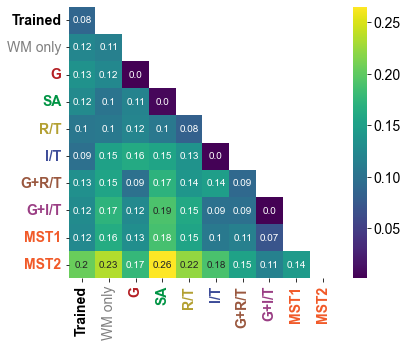

In [200]:
network_names = [all_networks[x]['display_name'] for x in all_networks if 'neural' not in all_networks[x]]
network_names = [all_networks[x]['display_name'] for x in all_networks]
network_colors = [all_networks[x]['color'] for x in all_networks]

show_raw_matrix = False
if show_raw_matrix:
    fig = plt.figure(figsize=(10, 8))
    plt.rc('font', **{'family': 'Arial', 'weight': 'normal', 'size': 14})
    ax = sns.heatmap(dist, cmap="viridis")
    plt.show()

fig = plt.figure(figsize=(6, 5))
plt.rc('font', **{'family': 'Arial', 'weight': 'normal', 'size': 14})
n_networks = len(network_names)
dist_ave = np.zeros((n_networks, n_networks))
for i in range(n_networks):
    for j in range(n_networks):
        temp = np.copy(dist[list(all_networks.values())[i]['ids'], :][:, list(all_networks.values())[j]['ids']])
        if i==j: 
            for k in range(len(temp)):
                temp[k, k] = None # remove diagonal elements
        dist_ave[i, j] = np.nanmean(temp)
        if i<j: dist_ave[i, j] = None  # remove top triangle (redundant)
ax = sns.heatmap(dist_ave, cmap="viridis", annot=((dist_ave*100).astype(int)/100).astype(str), annot_kws={'fontsize': 10}, fmt='s')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.xticks(np.linspace(0.5, len(network_names)-.5, len(network_names)), network_names)
plt.yticks(np.linspace(0.5, len(network_names)-.5, len(network_names)), network_names)
for i, ticklabel in enumerate(ax.get_xticklabels()):
    ticklabel.set_color(network_colors[i])
    if i!= 1: ticklabel.set_weight('bold')
for i, ticklabel in enumerate(ax.get_yticklabels()):
    ticklabel.set_color(network_colors[i])
    if i!= 1: ticklabel.set_weight('bold')
#plt.savefig('paper_figures/_procrustes_distance_matrix.pdf', bbox_inches='tight')

Perplexity value 500 is too high. Using perplexity 65.33 instead


Text(0.5, 0, 'tSNE dim2 (arbitrary units)')

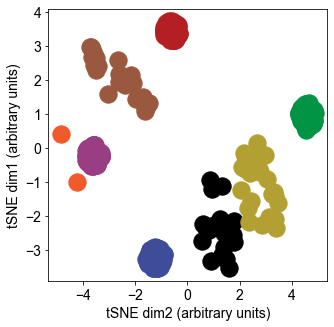

In [201]:
import openTSNE
tsne = openTSNE.TSNE(
    perplexity=500,  # always use maximum possible perplexity, to preserve global structure
    metric='precomputed',
    verbose=False,
    initialization='spectral',
)

max_networks = 30
include = "gating,inversion,reshuffle,notricks,backprop_la0".split(',')
include = list(all_networks.keys())
exclude = [x for x in include if ("backprop" in x and x!="backpropdd")]#["backprop", "backprop_pt_la"]#["inv+gat"]
#exclude += "diego_phd_mst,diego_new_mst".split(',')
exclude=['reshuffle', 'backprop']
exclude = ['reshuffle', 'reshuffle_ad_blr', 'backprop_la']
exclude = ['backprop_nd']#, 'mendoza_halliday_et_al_2014', 'mendoza_halliday_et_al_2023']
include = [x for x in include if x not in exclude]
ids = np.concatenate([(all_networks[name]['ids'])[:max_networks] for name in include])
embedding = tsne.fit(dist[ids, :][:, ids])
fig = plt.figure(figsize=(5, 5))
plt.rc('font', **{'family': 'Arial', 'weight': 'normal', 'size': 14})
i = 0
for name, network in all_networks.items():
    if name not in include: continue
    n = min(len(network['ids']), max_networks)
    plt.scatter(-embedding[i:i+n, 1], embedding[i:i+n, 0], 300, marker='o',color=network['color'], label=name, alpha=1)
    i += n
plt.ylabel("tSNE dim1 (arbitrary units)")
plt.xlabel("tSNE dim2 (arbitrary units)")
#plt.xticks([])
#plt.yticks([])
#plt.xlim(-5, 6.5)
#plt.ylim(-4.5, 6)
#plt.legend()
#plt.gca().axis('off')
#plt.savefig("tSNE.pdf", bbox_inches = 'tight')
#plt.savefig('paper_figures/_procrustes_distance_tSNE.pdf', bbox_inches='tight')

# Step 3: Distance from MST to RNN solutions

In [202]:

import numpy as np# https://stackoverflow.com/questions/11788950/importing-numpy-into-functions

def computeWilliams2021(Xtrain, Ytrain, Xtest, Ytest, VARIANCEEXPLAINED_KEEP=None, n_PCs_KEEP=None, alpha=1, PLOTFIGURES=0):
    ##########################################################################
    # INPUTS
    # Xtrain: (p, n_datapoints_train) array, p and q can be different but n_datapoints_train must be the same for both datasets. The PCA eigenvectors for Xtrain and Xtest are determined with training data from Xtrain.
    # Ytrain: (q, n_datapoints_train) array, p and q can be different but n_datapoints_train must be the same for both datasets. The PCA eigenvectors for Ytrain and Ytest are determined with training data from Ytrain. 
    # Xtest:  (p, n_datapoints_test) array, p and q can be different but n_datapoints_test must be the same for both datasets
    # Ytest:  (q, n_datapoints_test) array, p and q can be different but n_datapoints_test must be the same for both datasets
    # For example, when comparing neural recordings taken over time, p and q = number of neurons and n_datapoints = number of timesteps
    
    # VARIANCEEXPLAINED_KEEP is a number from 0 to 1. Before Williams2021, perform PCA on Xtrain and Ytrain separately. Project Xtrain and Ytrain onto k eigenvectors such that the fraction of variance explained by k is at least VARIANCEEXPLAINED. The value of k may be different for Xtrain and Ytrain.
    # n_PCs_KEEP: Before Williams2021, perform PCA on Xtrain and Ytrain separately. Project Xtrain and Ytrain onto n_PCs_KEEP eigenvectors. 
    # Xtrain and Ytrain are first reduced using PCA. This ensures that Williams2021 does not rely on low variance dimensions.
    # Use the PCs/eigenvectors found on Xtrain to reduce the dimensionality of Xtest before computing Williams2021 distance
    # Use the PCs/eigenvectors found on Ytrain to reduce the dimensionality of Ytest before computing Williams2021 distance
    # If both options are None then don't perform PCA
    
    # Valid values for the regularization term are 0 <= alpha <= 1. When alpha == 0, the resulting metric is similar to CCA and allows for an invertible linear transformation to align the activations. 
    # When alpha == 1, the model is fully regularized and only allows for rotational alignments.
    # We recommend starting with the fully regularized model where alpha == 1.

    # OUTPUTS
    # Williams2021_train_distance: a number between 0(most similar) and something (can be greater than 1) quantifying the similarity between Xtrain and Ytrain, potentially after projecting Xtrain and Ytrain onto some lower dimensional space with PCA
    # Williams2021_test_distance: a number between 0(most similar) and something (can be greater than 1) quantifying the similarity between Xtest and Ytest, potentially after projecting Xtest and Ytest onto some lower dimensional space with PCA
    # The output of metric.score from Williams2021 is np.arccos(C) where C is some number that technically is bounded between -1 and 1, so Williams2021 distance is bounded between 0 and pi
    # However, C seems to always fall between 0 and 1 so then Williams2021 distance is bounded between 0 and pi/2
    ##########################################################################
    assert np.sum((VARIANCEEXPLAINED_KEEP is None) + (n_PCs_KEEP is None)) > 0, "Error: One option can be None or both options can be None. If both options are None then PCA is not performed."
    
    if (VARIANCEEXPLAINED_KEEP is not None) or (n_PCs_KEEP is not None):# if both options are None then don't perform PCA 
        from sklearn.decomposition import PCA 
        for iteration in range(2):# 0) perform PCA on X, 1) perform PCA on Y
            if iteration==0: data = Xtrain; data_test = Xtest; namePCA = 'X'; figuresuffix = ''
            if iteration==1: data = Ytrain; data_test = Ytest; namePCA = 'Y'; figuresuffix = ''
            
            datadimensionality, n_datapoints = np.shape(data)# datadimensionality x n_datapoints array
            meandata = 1/n_datapoints * np.sum(data,1)# (datadimensionality,) array
            #dataminusmean_check = data - np.outer(meandata,np.ones(n_datapoints))# datadimensionality x n_datapoints array
            dataminusmean = data - meandata[:,None]# datadimensionality x n_datapoints array
            #print(f"Do dataminusmean and dataminusmean_check have the same shape and are element-wise equal within a tolerance? {dataminusmean.shape == dataminusmean_check.shape and np.allclose(dataminusmean, dataminusmean_check)}")
            
            # [u,s,v] = svd(A); A = u*s*v’; columns of u are eigenvectors of covariance matrix A*A’; rows of v’ are eigenvectors of covariance matrix A’*A; s is a diagonal matrix that has elements = sqrt(eigenvalues of A’*A and A*A’)
            #eigVec, eigVal, vT = np.linalg.svd(dataminusmean/np.sqrt(n_datapoints-1))# np.linalg.svd returns v transpose!
            #eigVal = eigVal**2# (datadimensionality,) array, largest first, np.sum(np.var(data, axis=1, ddof=1)) is the same as np.sum(eigVal)
            
            modelPCA = PCA(n_components = min(datadimensionality,n_datapoints)).fit(data.T)
            eigVal = modelPCA.explained_variance_# (datadimensionality,) array, largest is first 
            eigVec = modelPCA.components_.T# eigVec[:,i] is the ith eigenvector/principal component

            
            fraction = eigVal/np.sum(eigVal)# fraction of variance explained by each eigenvector
            if VARIANCEEXPLAINED_KEEP is not None:
                if VARIANCEEXPLAINED_KEEP==1:
                    n_PCs_KEEP = eigVec.shape[1]# keep all PCs
                else:
                    VARIANCEEXPLAINED = VARIANCEEXPLAINED_KEEP# a number from 0 to 1
                    n_PCs_KEEP = np.where(np.cumsum(fraction) >= VARIANCEEXPLAINED)[0] + 1# minimum number of principal components required to explain at least VARIANCEEXPLAINED% of the variance
                    n_PCs_KEEP = n_PCs_KEEP[0]
                
            # project the data onto the first k eigenvectors
            k = datadimensionality
            k = n_PCs_KEEP
            datanew = np.matmul(eigVec[:,0:k].T, dataminusmean)# k(dimension) x n_datapoints array, np.var(datanew, axis=1, ddof=1) is the same as eigVal
            datanew_test = np.matmul(eigVec[:,0:k].T, (data_test - meandata[:,None]))# k(dimension) x n_datapoints array, np.var(datanew, axis=1, ddof=1) is the same as eigVal
            
            if PLOTFIGURES:
                VARIANCEEXPLAINED = 0.5# a number from 0 to 1
                n_PCs50 = np.where(np.cumsum(fraction) >= VARIANCEEXPLAINED)[0] + 1# minimum number of principal components required to explain at least VARIANCEEXPLAINED% of the variance
                n_PCs50 = n_PCs50[0]
                VARIANCEEXPLAINED = 0.9# a number from 0 to 1
                n_PCs90 = np.where(np.cumsum(fraction) >= VARIANCEEXPLAINED)[0] + 1# minimum number of principal components required to explain at least VARIANCEEXPLAINED% of the variance
                n_PCs90 = n_PCs90[0]
                VARIANCEEXPLAINED = 0.95# a number from 0 to 1
                n_PCs95 = np.where(np.cumsum(fraction) >= VARIANCEEXPLAINED)[0] + 1# minimum number of principal components required to explain at least VARIANCEEXPLAINED% of the variance
                n_PCs95 = n_PCs95[0]
                VARIANCEEXPLAINED = 0.99# a number from 0 to 1
                n_PCs99 = np.where(np.cumsum(fraction) >= VARIANCEEXPLAINED)[0] + 1# minimum number of principal components required to explain at least VARIANCEEXPLAINED% of the variance
                n_PCs99 = n_PCs99[0]
                
                import matplotlib.pyplot as plt
                # The sum of the variance-along-each-axis is preserved under a rotation of the axes, e.g. np.sum(eigVal) = np.sum(np.var(data, axis=1, ddof=1))
                # In other words, the variance of neuron 1 over time + variance of neuron 2 over time + ... + variance of last neuron over time = sum of variances after projecting data onto each principal component
                var_data = np.var(data.copy(), axis=1, ddof=1)# not sorted
                indices = np.argsort(-var_data)# sort the variances in decreasing order, so largest is first
                var_data = var_data[indices]# largest variance is first                  
                cumulative_fraction_var_data = np.cumsum(var_data) / np.sum(var_data)
                
                var_datanew = np.var(datanew.copy(), axis=1, ddof=1)# not sorted
                #indices = np.argsort(-var_datanew)# sort the variances in decreasing order, so largest is first
                #var_datanew = var_datanew[indices]# largest variance is first                  
                #cumulative_fraction_var_datanew = np.cumsum(var_datanew) / np.sum(var_datanew)# np.sum(var_datanew) may not be the same as np.sum(var_data)=np.sum(eigVal) if data is projected onto fewer dimensions
                cumulative_fraction_var_datanew = np.cumsum(var_datanew) / np.sum(eigVal)
                
                fig, ax = plt.subplots()# cumulative fraction of total variance-along-each-axis
                fontsize = 14
                handle1 = ax.plot(np.arange(1,datadimensionality+1), cumulative_fraction_var_data, 'r-', linewidth=3)
                handle2 = ax.plot(np.arange(1,datadimensionality+1), np.cumsum(eigVal)/np.sum(eigVal), 'k-', linewidth=3)
                handle3 = ax.plot(np.arange(1,k+1), cumulative_fraction_var_datanew, 'k.')# fraction of variance kept in k-dimensional projection
                ax.legend(handles=[handle1[0],handle2[0]], labels=['Original data','Data projected onto PCA axes'], loc='best', frameon=True)
                ax.set_xlabel('Number of axes', fontsize=fontsize)
                ax.set_ylabel('Cumulative fraction of total variance-along-each-axis', fontsize=fontsize)
                ax.set_title(f'{n_PCs50} principal components explain {100*np.sum(eigVal[0:n_PCs50])/np.sum(eigVal):.0f}% of the variance\n\
                             {n_PCs90} principal components explain {100*np.sum(eigVal[0:n_PCs90])/np.sum(eigVal):.0f}% of the variance\
                             \n{n_PCs95} principal components explain {100*np.sum(eigVal[0:n_PCs95])/np.sum(eigVal):.0f}% of the variance\n\
                {n_PCs99} principal components explain {100*np.sum(eigVal[0:n_PCs99])/np.sum(eigVal):.0f}% of the variance\
                \n{n_PCs_KEEP} principal components explain {100*np.sum(eigVal[0:n_PCs_KEEP])/np.sum(eigVal):.0f}% of the variance', fontsize=fontsize)
                ax.set_xlim(xmin=None, xmax=None); ax.set_ylim(ymin=0, ymax=None)
                ax.tick_params(axis='both', labelsize=fontsize)
                #fig.savefig('%s/PCA_variance_%s%s.pdf'%(dir,namePCA.replace(" ", ""),figuresuffix), bbox_inches='tight');# add bbox_inches='tight' to keep title from being cutoff
                fig.savefig('PCA_variance_%s%s.pdf'%(namePCA.replace(" ", ""),figuresuffix), bbox_inches='tight');# add bbox_inches='tight' to keep title from being cutoff
                
            if iteration==0: Xtrain = datanew.copy(); Xtest = datanew_test.copy()# use B = A.copy() so changing B doesn't change A (also changing A doesn't change B)
            if iteration==1: Ytrain = datanew.copy(); Ytest = datanew_test.copy()# use B = A.copy() so changing B doesn't change A (also changing A doesn't change B)  
        
    
    metric = LinearMetric(alpha=alpha, center_columns=True)
    metric.fit(Xtrain.T, Ytrain.T)# fit alignment transformations
    Williams2021_train_distance = metric.score(Xtrain.T, Ytrain.T)# evaluate distance between X and Y, using alignments fit above
    Williams2021_test_distance = metric.score(Xtest.T, Ytest.T)# evaluate distance between X and Y, using alignments fit above
    
    return Williams2021_train_distance, Williams2021_test_distance




def computeWilliams2021_crossconditionvalidation(X, Y, VARIANCEEXPLAINED_KEEP=None, n_PCs_KEEP=None, alpha=1):
    ##########################################################################
    # INPUTS
    # X: (p, n_datapoints, n_conditions) array, p and q can be different but n_datapoints and n_conditions must be the same for both datasets
    # Y: (q, n_datapoints, n_conditions) array, p and q can be different but n_datapoints and n_conditions must be the same for both datasets
    # For example, when comparing neural recordings taken over time, p and q = number of neurons and n_datapoints = number of timesteps
    
    # PCA eigenvectors are determined with data from X and Y across all conditions except one. The one condition serves as the test data for cross-validation. This process is repeated for all conditions.
    # For each condition create the following arrays and call the function computeWilliams2021
    # Xtrain = X[:,:,all-conditions-except-condition-icondition]: (p, n_datapoints_train) array, p and q can be different but n_datapoints_train must be the same for both datasets. The PCA eigenvectors for Xtrain and Xtest are determined with training data from Xtrain.
    # Ytrain = Y[:,:,all-conditions-except-condition-icondition]: (q, n_datapoints_train) array, p and q can be different but n_datapoints_train must be the same for both datasets. The PCA eigenvectors for Ytrain and Ytest are determined with training data from Ytrain.
    # Xtest = X[:,:,icondition]:  (p, n_datapoints_test) array, p and q can be different but n_datapoints_test must be the same for both datasets
    # Ytest = Y[:,:,icondition]:  (q, n_datapoints_test) array, p and q can be different but n_datapoints_test must be the same for both datasets
    
    # VARIANCEEXPLAINED_KEEP is a number from 0 to 1. Before Williams2021, perform PCA on Xtrain and Ytrain separately. Project Xtrain and Ytrain onto k eigenvectors such that the fraction of variance explained by k is at least VARIANCEEXPLAINED. The value of k may be different for Xtrain and Ytrain.
    # n_PCs_KEEP: Before Williams2021, perform PCA on Xtrain and Ytrain separately. Project Xtrain and Ytrain onto n_PCs_KEEP eigenvectors. 
    # Xtrain and Ytrain are first reduced using PCA. This ensures that Williams2021 does not rely on low variance dimensions.
    # Use the PCs/eigenvectors found on Xtrain to reduce the dimensionality of Xtest before computing Williams2021 distance
    # Use the PCs/eigenvectors found on Ytrain to reduce the dimensionality of Ytest before computing Williams2021 distance
    # If both options are None then don't perform PCA
    
    # Valid values for the regularization term are 0 <= alpha <= 1. When alpha == 0, the resulting metric is similar to CCA and allows for an invertible linear transformation to align the activations. 
    # When alpha == 1, the model is fully regularized and only allows for rotational alignments.
    # We reccomend starting with the fully regularized model where alpha == 1.

    # OUTPUTS
    # Williams2021_train: (n_conditions,) array, Williams2021_train[j] contains a number between 0 and something (can be greater than 1) quantifying the similarity between all data in X and Y that is not from condition icondition
    # Williams2021_test:  (n_conditions,) array, Williams2021_test[j] contains a number between 0 and something (can be greater than 1) quantifying the similarity between data from X[:,:,icondition] and Y[:,:,icondition]
    ##########################################################################
    assert np.sum((VARIANCEEXPLAINED_KEEP is None) + (n_PCs_KEEP is None)) > 0, "Error: One option can be None or both options can be None. If both options are None then PCA is not performed."
    
    
    p, n_datapoints, n_conditions = X.shape
    q, n_datapoints, n_conditions = Y.shape
    Williams2021_train = -700*np.ones(n_conditions)
    Williams2021_test = -700*np.ones(n_conditions)
    for iconditiontest in range(n_conditions):# test on data from condition icondition
        
        iconditionstrain = np.arange(0,n_conditions)# indices of all conditions 
        iconditionstrain = np.delete(iconditionstrain, iconditiontest)# indices of all conditions except icondition
        
        Xtrain = X[:,:,iconditionstrain].reshape(p,n_datapoints*(n_conditions-1), order='F')# (p, n_datapoints_train) array
        Ytrain = Y[:,:,iconditionstrain].reshape(q,n_datapoints*(n_conditions-1), order='F')# (q, n_datapoints_train) array
        '''
        Xtrain_check = -700*np.ones((p,n_datapoints*(n_conditions-1)))# (p, n_datapoints_train) array
        Ytrain_check = -700*np.ones((q,n_datapoints*(n_conditions-1)))# (q, n_datapoints_train) array
        ifill = 0
        for icondition in iconditionstrain:
            Xtrain_check[:,ifill*n_datapoints:(ifill+1)*n_datapoints] = X[:,:,icondition]# (p, n_datapoints) array
            Ytrain_check[:,ifill*n_datapoints:(ifill+1)*n_datapoints] = Y[:,:,icondition]# (q, n_datapoints) array
            ifill = ifill + 1
        print(f"Do Xtrain and Xtrain_check have the same shape and are element-wise equal within a tolerance? {Xtrain.shape == Xtrain_check.shape and np.allclose(Xtrain, Xtrain_check)}")
        print(f"Do Ytrain and Ytrain_check have the same shape and are element-wise equal within a tolerance? {Ytrain.shape == Ytrain_check.shape and np.allclose(Ytrain, Ytrain_check)}")
        '''
        Xtest = X[:,:,iconditiontest]# (p, n_datapoints_test) array
        Ytest = Y[:,:,iconditiontest]# (q, n_datapoints_test) array
        
        Williams2021_train_, Williams2021_test_ = computeWilliams2021(Xtrain, Ytrain, Xtest, Ytest, VARIANCEEXPLAINED_KEEP=VARIANCEEXPLAINED_KEEP, n_PCs_KEEP=n_PCs_KEEP, alpha=alpha, PLOTFIGURES=0)    
        Williams2021_train[iconditiontest] = Williams2021_train_
        Williams2021_test[iconditiontest] = Williams2021_test_
 
    return Williams2021_train, Williams2021_test

def computedistance(Xtrain, Ytrain, Xtest, Ytest, VARIANCEEXPLAINED_KEEP=None, n_PCs_KEEP=None, similarityname='Williams2021', NORMALIZE_BETWEEN0AND1=1):
    ##########################################################################
    # INPUTS
    # Xtrain: (p, n_datapoints_train) array, p and q can be different but n_datapoints_train must be the same for both datasets. The PCA eigenvectors for Xtrain and Xtest are determined with training data from Xtrain.
    # Ytrain: (q, n_datapoints_train) array, p and q can be different but n_datapoints_train must be the same for both datasets. The PCA eigenvectors for Ytrain and Ytest are determined with training data from Ytrain. 
    # Xtest:  (p, n_datapoints_test) array, p and q can be different but n_datapoints_test must be the same for both datasets
    # Ytest:  (q, n_datapoints_test) array, p and q can be different but n_datapoints_test must be the same for both datasets
    # For example, when comparing neural recordings taken over time, p and q = number of neurons and n_datapoints = number of timesteps
    
    # VARIANCEEXPLAINED_KEEP is a number from 0 to 1. Before computing the distance measure, perform PCA on Xtrain and Ytrain separately. Project Xtrain and Ytrain onto k eigenvectors such that the fraction of variance explained by k is at least VARIANCEEXPLAINED. The value of k may be different for Xtrain and Ytrain.
    # n_PCs_KEEP: Before computing the distance measure, perform PCA on Xtrain and Ytrain separately. Project Xtrain and Ytrain onto n_PCs_KEEP eigenvectors. 
    # Xtrain and Ytrain are first reduced using PCA. This ensures that the distance measure does not rely on low variance dimensions.
    # Use the PCs/eigenvectors found on Xtrain to reduce the dimensionality of Xtest before computing the distance
    # Use the PCs/eigenvectors found on Ytrain to reduce the dimensionality of Ytest before computing the distance
    # If both options are None then don't perform PCA
    
    # OUTPUTS
    # distance_train: a number between 0 and 1(most similar) quantifying the similarity between Xtrain and Ytrain, potentially after projecting Xtrain and Ytrain onto some lower dimensional space with PCA
    # distance_test: a number between 0 and 1(most similar) quantifying the similarity between Xtest and Ytest, potentially after projecting Xtest and Ytest onto some lower dimensional space with PCA
    ##########################################################################
    assert np.sum((VARIANCEEXPLAINED_KEEP is None) + (n_PCs_KEEP is None)) > 0, "Error: One option can be None or both options can be None. If both options are None then PCA is not performed."
    
    #---------------
    if similarityname == 'CCA': 
        CCA_train, CCA_test = computeCCA(Xtrain, Ytrain, Xtest, Ytest, VARIANCEEXPLAINED_KEEP, n_PCs_KEEP, n_CCs_KEEP=None)
        distance_train = 1 - np.mean(CCA_train)# convert all numbers to distances so CCA distance = 1 - CCA similarity, varies between 0(most similar) and 1
        distance_test = 1 - np.mean(CCA_test)# convert all numbers to distances so CCA distance = 1 - CCA similarity, varies between 0(most similar) and 1
    #---------------
    if similarityname == 'CKA': 
        CKA_train, CKA_test = computeCKA(Xtrain, Ytrain, Xtest, Ytest, VARIANCEEXPLAINED_KEEP, n_PCs_KEEP)
        distance_train = 1 - CKA_train# convert all numbers to distances so CKA distance = 1 - CKA similarity, varies between 0(most similar) and 1
        distance_test = 1 - CKA_test# convert all numbers to distances so CKA distance = 1 - CKA similarity, varies between 0(most similar) and 1
    #---------------
    if similarityname == 'metricCKA': 
        distance_train, distance_test = computemetricCKA(Xtrain, Ytrain, Xtest, Ytest, VARIANCEEXPLAINED_KEEP, n_PCs_KEEP)
        # convert all numbers to distances, metricCKA distance varies between 0(most similar) and pi/2
        if NORMALIZE_BETWEEN0AND1:
            distance_train = distance_train / (np.pi/2)# scale distance to be between 0(most similar) and 1
            distance_test = distance_test / (np.pi/2)# scale distance to be between 0(most similar) and 1
    #---------------
    if similarityname == 'Williams2021': 
        distance_train, distance_test = computeWilliams2021(Xtrain, Ytrain, Xtest, Ytest, VARIANCEEXPLAINED_KEEP, n_PCs_KEEP, alpha=1)
        # convert all numbers to distances, Williams2021 distance varies between 0(most similar) and something(can be greater than 1)
        # The output of metric.score from Williams2021 is np.arccos(C) where C is some number that technically is bounded between -1 and 1, so Williams2021 distance is bounded between 0 and pi
        # However, C seems to always fall between 0 and 1 so then Williams2021 distance is bounded between 0 and pi/2
        if NORMALIZE_BETWEEN0AND1:
            distance_train = distance_train / (np.pi/2)# scale distance to be between 0(most similar) and 1
            distance_test = distance_test / (np.pi/2)# scale distance to be between 0(most similar) and 1
    #---------------   
    return distance_train, distance_test
   
    
   
    
    
def computedistance_crossconditionvalidation(X, Y, VARIANCEEXPLAINED_KEEP=None, n_PCs_KEEP=None, similarityname='Williams2021', NORMALIZE_BETWEEN0AND1=1):
     ##########################################################################
     # INPUTS
     # X: (p, n_datapoints, n_conditions) array, p and q can be different but n_datapoints and n_conditions must be the same for both datasets
     # Y: (q, n_datapoints, n_conditions) array, p and q can be different but n_datapoints and n_conditions must be the same for both datasets
     # For example, when comparing neural recordings taken over time, p and q = number of neurons and n_datapoints = number of timesteps
     # similarityname: string 'CCA' 'CKA' 'metricCKA' 'Williams2021'
     
     # PCA eigenvectors are determined with data from X and Y across all conditions except one. The one condition serves as the test data for cross-validation. This process is repeated for all conditions.
     # For each condition create the following arrays and call the function computeWilliams2021
     # Xtrain = X[:,:,all-conditions-except-condition-icondition]: (p, n_datapoints_train) array, p and q can be different but n_datapoints_train must be the same for both datasets. The PCA eigenvectors for Xtrain and Xtest are determined with training data from Xtrain.
     # Ytrain = Y[:,:,all-conditions-except-condition-icondition]: (q, n_datapoints_train) array, p and q can be different but n_datapoints_train must be the same for both datasets. The PCA eigenvectors for Ytrain and Ytest are determined with training data from Ytrain.
     # Xtest = X[:,:,icondition]:  (p, n_datapoints_test) array, p and q can be different but n_datapoints_test must be the same for both datasets
     # Ytest = Y[:,:,icondition]:  (q, n_datapoints_test) array, p and q can be different but n_datapoints_test must be the same for both datasets
     
     # VARIANCEEXPLAINED_KEEP is a number from 0 to 1. Before computing the distance measure, perform PCA on Xtrain and Ytrain separately. Project Xtrain and Ytrain onto k eigenvectors such that the fraction of variance explained by k is at least VARIANCEEXPLAINED. The value of k may be different for Xtrain and Ytrain.
     # n_PCs_KEEP: Before computing the distance measure, perform PCA on Xtrain and Ytrain separately. Project Xtrain and Ytrain onto n_PCs_KEEP eigenvectors. 
     # Xtrain and Ytrain are first reduced using PCA. This ensures that the distance measure does not rely on low variance dimensions.
     # Use the PCs/eigenvectors found on Xtrain to reduce the dimensionality of Xtest before computing the distance
     # Use the PCs/eigenvectors found on Ytrain to reduce the dimensionality of Ytest before computing the distance
     # If both options are None then don't perform PCA
     
     # OUTPUTS
     # distance_train (n_conditions,) array contains a number between 0 and something (can be greater than 1) quantifying the similarity between all data in X and Y that is not from condition icondition
     # distance_test (n_conditions,) array contains a number between 0 and something (can be greater than 1) quantifying the similarity between data from X[:,:,icondition] and Y[:,:,icondition]
     ##########################################################################
     assert np.sum((VARIANCEEXPLAINED_KEEP is None) + (n_PCs_KEEP is None)) > 0, "Error: One option can be None or both options can be None. If both options are None then PCA is not performed."
    
     
     #---------------
     if similarityname == 'CCA': 
         CCA_train, CCA_test = computeCCA_crossconditionvalidation(X, Y, VARIANCEEXPLAINED_KEEP=VARIANCEEXPLAINED_KEEP, n_PCs_KEEP=n_PCs_KEEP)
         distance_train = 1 - CCA_train# convert all numbers to distances so CCA distance = 1 - CCA similarity, varies between 0(most similar) and 1
         distance_test = 1 - CCA_test# convert all numbers to distances so CCA distance = 1 - CCA similarity, varies between 0(most similar) and 1
     #---------------
     if similarityname == 'CKA': 
         CKA_train, CKA_test = computeCKA_crossconditionvalidation(X, Y, VARIANCEEXPLAINED_KEEP=VARIANCEEXPLAINED_KEEP, n_PCs_KEEP=n_PCs_KEEP)
         distance_train = 1 - CKA_train# convert all numbers to distances so CKA distance = 1 - CKA similarity, varies between 0(most similar) and 1
         distance_test = 1 - CKA_test# convert all numbers to distances so CKA distance = 1 - CKA similarity, varies between 0(most similar) and 1
     #---------------
     if similarityname == 'metricCKA': 
         distance_train, distance_test = computemetricCKA_crossconditionvalidation(X, Y, VARIANCEEXPLAINED_KEEP=VARIANCEEXPLAINED_KEEP, n_PCs_KEEP=n_PCs_KEEP)
         # convert all numbers to distances, metricCKA distance varies between 0(most similar) and pi/2
         if NORMALIZE_BETWEEN0AND1:
             distance_train = distance_train / (np.pi/2)# scale distance to be between 0(most similar) and 1
             distance_test = distance_test / (np.pi/2)# scale distance to be between 0(most similar) and 1
     #---------------
     if similarityname == 'Williams2021': 
         distance_train, distance_test = computeWilliams2021_crossconditionvalidation(X, Y, VARIANCEEXPLAINED_KEEP=VARIANCEEXPLAINED_KEEP, n_PCs_KEEP=n_PCs_KEEP)# (n_conditions,)
         # convert all numbers to distances, Williams2021 distance varies between 0(most similar) and something(can be greater than 1)
         # The output of metric.score from Williams2021 is np.arccos(C) where C is some number that technically is bounded between -1 and 1, so Williams2021 distance is bounded between 0 and pi
         # However, C seems to always fall between 0 and 1 so then Williams2021 distance is bounded between 0 and pi/2
         if NORMALIZE_BETWEEN0AND1:
             distance_train = distance_train / (np.pi/2)# scale distance to be between 0(most similar) and 1
             distance_test = distance_test / (np.pi/2)# scale distance to be between 0(most similar) and 1
     #---------------   
     return distance_train, distance_test# (n_conditions,) array
    

# Return a distance that is normalized between ~0(best) and ~1(worst)
# 
# Split neural data into nonoverlapping groups each containing n_sample neurons (ineurons1, ineurons2)
# Sample n_sample units from the RNN model (iunits)
# Compute distance between two samples of neural data d1 = D(ineurons2, ineurons1). d1 is the lowest we can hope to get given the variability in the neurons that were recorded.
# Compute distance between samples of the model and neural data d2 = D(iunits, ineurons1)
# Map distances from old interval [d1,1] to new interval [0,1]. I'm assuming d1 and d2 are normalized distances between [0,1].
# distance_normalized = (d2 - d1) / (1 - d1)

# Do the same thing for the cross-condition average dataset. Sample ineurons2 from cross-condition average dataset and compute d3 = D(ineurons2, ineurons1)
# Note that ineurons2 is a different set of neurons than ineurons1, as this more closely replicates the comparison to a model that has different neurons
# distance_normalized_baseline = (d3 - d1) / (1 - d1)

# For each iteration of this procedure we get a new estimate for the normalized distance.
# The final normalized distance is the mean of all of these estimates.


def computedistance_normalizedwithdata(X_neuraldata, Y, similarityname, VARIANCEEXPLAINED_KEEP=None, n_PCs_KEEP=None, n_sample=10, n_iterations=100, random_seed=1):
     # INPUTS
     # X_neuraldata: (p, n_datapoints, n_conditions) array, p and q can be different but n_datapoints and n_conditions must be the same for both datasets
     # Y:            (q, n_datapoints, n_conditions) array, p and q can be different but n_datapoints and n_conditions must be the same for both datasets
     # For example, when comparing neural recordings taken over time, p and q = number of neurons and n_datapoints = number of timesteps
     # similarityname: string 'CCA' 'CKA' 'metricCKA' 'Williams2021'
     
     # VARIANCEEXPLAINED_KEEP is a number from 0 to 1. Before computing the distance measure, perform PCA on Xtrain and Ytrain separately. Project Xtrain and Ytrain onto k eigenvectors such that the fraction of variance explained by k is at least VARIANCEEXPLAINED. The value of k may be different for Xtrain and Ytrain.
     # n_PCs_KEEP: Before computing the distance measure, perform PCA on Xtrain and Ytrain separately. Project Xtrain and Ytrain onto n_PCs_KEEP eigenvectors. 
     # Xtrain and Ytrain are first reduced using PCA. This ensures that the distance measure does not rely on low variance dimensions.
     # Use the PCs/eigenvectors found on Xtrain to reduce the dimensionality of Xtest before computing the distance
     # Use the PCs/eigenvectors found on Ytrain to reduce the dimensionality of Ytest before computing the distance
     # If both options are None then don't perform PCA
    
     # n_sample: all distances are computed between between n_sample neurons/units
     # n_iterations: compute normalized distance n_iterations times with different samples from X and Y on each iteration
     # random_seed: random seed that determines the random samples
     
     # OUTPUTS
     # distance_normalized (n_iterations,) array contains a number between 0(best) and 1(worst) quantifying the similarity between all data in X_neuraldata and Y 
     # distance_normalized_baseline (n_iterations,) array contains a number between 0(best) and 1(worst) quantifying the similarity between all data in X_neuraldata and X_crossconditionaverage
     ##########################################################################
     assert np.sum((VARIANCEEXPLAINED_KEEP is None) + (n_PCs_KEEP is None)) > 0, "Error: One option can be None or both options can be None. If both options are None then PCA is not performed."
     n_sample_max = np.floor(X_neuraldata.shape[0]/2)
     assert n_sample <= n_sample_max, "Error: to compute the neural/neural distance the neural data is split into two nonoverlapping groups so n_sample must not be greater than n_neurons/2"
     
     # cross-condition average baseline for model/data similarity is computed using only neural data
     # compare original neural dataset to one in which each neuron's firing rate across conditions is replaced by a single time varying firing rate that is obtained after averaging across conditions (each neuron can have a different time varying firing rate in this baseline dataset)
     [n_neurons, n_T, n_conditions] = X_neuraldata.shape
     X_crossconditionaverage = -700*np.ones((n_neurons, n_T, n_conditions))
     Xaverage = np.mean(X_neuraldata.copy(),2)# n_neurons x n_T array, average across conditions
     for icondition in range(n_conditions):
         X_crossconditionaverage[:,:,icondition] =  Xaverage.copy()# use B = A.copy() so changing B doesn't change A (also changing A doesn't change B)  
     #import sys; sys.exit()# stop script at current line
     
     rng = np.random.default_rng(random_seed)
     distance_normalized = -700*np.ones(n_iterations)# contains a number between 0(best) and 1(worst) quantifying the similarity between all data in X_neuraldata and Y 
     distance_normalized_baseline = -700*np.ones(n_iterations)# contains a number between 0(best) and 1(worst) quantifying the similarity between all data in X_neuraldata and X_crossconditionaverage
     distance_neuraltoneuralsubsampled_between0and1 = -700*np.ones(n_iterations)
     distance_modeltoneuralsubsampled_between0and1 = -700*np.ones(n_iterations)
     distance_crossconditionaverageneuraltoneuralsubsampled_between0and1 = -700*np.ones(n_iterations)
     distance_normalizedwithdata_output = {}# empty dictionary
     for iteration in range(n_iterations):
         ineurons1 = rng.permutation(n_neurons)[0:n_sample]# (n_sample,) array 
         ineurons2 = np.arange(0,n_neurons)# indices of all neurons
         ineurons2 = np.delete(ineurons2, ineurons1)# indices of all neurons except ineurons1
         ineurons2 = rng.permutation(ineurons2)# permute ineurons2
         assert len(np.intersect1d(ineurons1, ineurons2)) == 0, "Error: ineurons1 and ineurons2 should not contain any overlap"
         ineurons2 = ineurons2[0:n_sample]# (n_sample,) array 
         iunits = rng.permutation(Y.shape[0])[0:n_sample]# (n_sample,) array 
         #---------------
         # Xtrain: (p, n_datapoints_train) array, p and q can be different but n_datapoints_train must be the same for both datasets. The PCA eigenvectors for Xtrain and Xtest are determined with training data from Xtrain. The CCA weights for Xtrain and Xtest are determined with training data from Xtrain (after performing PCA) 
         # Ytrain: (q, n_datapoints_train) array, p and q can be different but n_datapoints_train must be the same for both datasets. The PCA eigenvectors for Ytrain and Ytest are determined with training data from Ytrain. The CCA weights for Ytrain and Ytest are determined with training data from Ytrain (after performing PCA) 
         # Xtest:  (p, n_datapoints_test) array, p and q can be different but n_datapoints_test must be the same for both datasets
         # Ytest:  (q, n_datapoints_test) array, p and q can be different but n_datapoints_test must be the same for both datasets
         # For example, when comparing neural recordings taken over time, p and q = number of neurons and n_datapoints = number of timesteps
         #---------------
         # Compute distance between two samples of neural data d1 = D(ineurons2, ineurons1). d1 is the lowest we can hope to get given the variability in the neurons that were recorded.
         Xtrain = X_neuraldata[ineurons1,:,:].reshape(ineurons1.size,n_T*n_conditions, order='F')
         Ytrain = X_neuraldata[ineurons2,:,:].reshape(ineurons2.size,n_T*n_conditions, order='F')
         Xtest = Xtrain.copy(); Ytest = Ytrain.copy()
         '''
         Xtrain_check = -700*np.ones((ineurons1.size,n_T*n_conditions))
         Ytrain_check = -700*np.ones((ineurons2.size,n_T*n_conditions))
         ifill = 0
         for icondition in range(n_conditions):
             Xtrain_check[:,ifill*n_T:(ifill+1)*n_T] = X_neuraldata[ineurons1,:,icondition]
             Ytrain_check[:,ifill*n_T:(ifill+1)*n_T] = X_neuraldata[ineurons2,:,icondition]
             ifill = ifill + 1
         print(f"Do Xtrain and Xtrain_check have the same shape and are element-wise equal within a tolerance? {Xtrain.shape == Xtrain_check.shape and np.allclose(Xtrain, Xtrain_check)}")
         print(f"Do Ytrain and Ytrain_check have the same shape and are element-wise equal within a tolerance? {Ytrain.shape == Ytrain_check.shape and np.allclose(Ytrain, Ytrain_check)}")
         '''
         d1, d1_test = computedistance(Xtrain, Ytrain, Xtest, Ytest, VARIANCEEXPLAINED_KEEP, n_PCs_KEEP, similarityname, NORMALIZE_BETWEEN0AND1=1)# a number between 0(most similar) and 1
         #---------------
         # Compute distance between samples of the model and neural data d2 = D(iunits, ineurons1)
         Xtrain = X_neuraldata[ineurons1,:,:].reshape(ineurons1.size,n_T*n_conditions, order='F')
         Ytrain = Y[iunits,:,:].reshape(iunits.size,n_T*n_conditions, order='F')
         Xtest = Xtrain.copy(); Ytest = Ytrain.copy()
         d2, d2_test = computedistance(Xtrain, Ytrain, Xtest, Ytest, VARIANCEEXPLAINED_KEEP, n_PCs_KEEP, similarityname, NORMALIZE_BETWEEN0AND1=1)# a number between 0(most similar) and 1
         #---------------
         # Do the same thing for the cross-condition average dataset. Sample ineurons2 from cross-condition average dataset and compute d3 = D(ineurons2, ineurons1)
         # Note that ineurons2 is a different set of neurons than ineurons1, as this more closely replicates the comparison to a model that has different neurons
         Xtrain = X_neuraldata[ineurons1,:,:].reshape(ineurons1.size,n_T*n_conditions, order='F')
         Ytrain = X_crossconditionaverage[ineurons2,:,:].reshape(ineurons2.size,n_T*n_conditions, order='F')
         Xtest = Xtrain.copy(); Ytest = Ytrain.copy()
         d3, d3_test = computedistance(Xtrain, Ytrain, Xtest, Ytest, VARIANCEEXPLAINED_KEEP, n_PCs_KEEP, similarityname, NORMALIZE_BETWEEN0AND1=1)# a number between 0(most similar) and 1
         #---------------
         # Map distances from old interval [d1,1] to new interval [0,1]
         d2_normalized = (d2 - d1) / (1 - d1)
         d3_normalized = (d3 - d1) / (1 - d1)
         distance_normalized[iteration] = d2_normalized# contains a number between 0(best) and 1(worst) quantifying the similarity between all data in X_neuraldata and Y 
         distance_normalized_baseline[iteration] = d3_normalized# contains a number between 0(best) and 1(worst) quantifying the similarity between all data in X_neuraldata and X_crossconditionaverage
         #---------------
         distance_neuraltoneuralsubsampled_between0and1[iteration] = d1
         distance_modeltoneuralsubsampled_between0and1[iteration] = d2
         distance_crossconditionaverageneuraltoneuralsubsampled_between0and1[iteration] = d3
     distance_normalizedwithdata_output['distance_normalizedwithdata'] = distance_normalized# (n_iterations,) array
     distance_normalizedwithdata_output['distance_normalizedwithdata_baseline'] = distance_normalized_baseline# (n_iterations,) array
     distance_normalizedwithdata_output['distance_neuraltoneuralsubsampled_between0and1'] = distance_neuraltoneuralsubsampled_between0and1# (n_iterations,) array
     distance_normalizedwithdata_output['distance_modeltoneuralsubsampled_between0and1'] = distance_modeltoneuralsubsampled_between0and1# (n_iterations,) array
     distance_normalizedwithdata_output['distance_crossconditionaverageneuraltoneuralsubsampled_between0and1'] = distance_crossconditionaverageneuraltoneuralsubsampled_between0and1# (n_iterations,) array
     #return distance_normalized, distance_normalized_baseline, distance_neuraltoneuralsubsampled_between0and1, distance_modeltoneuralsubsampled_between0and1, distance_crossconditionaverageneuraltoneuralsubsampled_between0and1# (n_iterations,) arrays
     return distance_normalizedwithdata_output  

In [203]:
metric = LinearMetric(alpha=1.0, zero_pad=True)

neuraldata_name = "mendoza_halliday_et_al_2023"
comparison_networks = [x for x in all_networks if x != neuraldata_name]

comparison_distances = []
for comparison_network in comparison_networks:
    if comparison_network is None: 
        comparison_distances.append(None)
        continue
        
    distances_a1a2 = []
    distances_a1b = []
    N_repeats = 100
    for i in range(N_repeats):
        array_a = arrays[all_networks[neuraldata_name]['ids'][0]]
        array_a = arrays[np.random.choice(all_networks[neuraldata_name]['ids'], replace=False)]
        array_b = arrays[np.random.choice(all_networks[comparison_network]['ids'], replace=False)]
        # Split the neural data in two groups (for noise ceiling calculation)
        n_samples = min(array_a.shape[1]//2, array_b.shape[1])
        indices_a = np.random.choice(np.arange(array_a.shape[1]), n_samples*2, replace=False)
        indices_a1 = indices_a[:n_samples]
        indices_a2 = indices_a[n_samples:]
        indices_b = np.random.choice(np.arange(array_b.shape[1]), n_samples, replace=False)
        
        X, Y = array_a[:, indices_a1], array_a[:, indices_a2]
        metric.fit(X, Y)
        dist_a1a2 = metric.score(X, Y) / np.pi * 2  # normalize the distances from [0, pi/2] to [0, 1]
        
        X, Y = array_a[:, indices_a1], array_b[:, indices_b]
        metric.fit(X, Y)
        dist_a1b = metric.score(X, Y) / np.pi * 2  # normalize the distances from [0, pi/2] to [0, 1] 
    
        distances_a1a2.append(dist_a1a2)
        distances_a1b.append(dist_a1b)
    distances_a1a2, distances_a1b = np.array(distances_a1a2), np.array(distances_a1b)
    comparison_distances.append(distances_a1b)

In [204]:
def calculate_model_distances_to_neural(neuraldata_name, save_figure=False):
    metric = LinearMetric(alpha=1.0, zero_pad=True)
    comparison_networks = [x for x in all_networks if x != neuraldata_name]
    
    comparison_distances = []
    noise_floor_distances = []
    for comparison_network in comparison_networks:
        if comparison_network is None: 
            comparison_distances.append(None)
            continue
    
        n_network_samples = 10
        comparison_distances.append([])
        for network_sample_i in range(n_network_samples):
            temp = np.copy(arrays[np.random.choice(all_networks[neuraldata_name]["ids"])].reshape(4, 2, -1))
            neuraldata = np.zeros((temp.shape[2], temp.shape[1], temp.shape[0]))
            for neuron_i in range(temp.shape[2]):
                for timestep_i in range(temp.shape[1]):
                    for condition_i in range(temp.shape[0]):
                        neuraldata[neuron_i, timestep_i, condition_i] = temp[condition_i, timestep_i, neuron_i]
            
            temp = np.copy(arrays[np.random.choice(all_networks[comparison_network]["ids"])].reshape(4, 2, -1))
            rnn_units = np.zeros((temp.shape[2], temp.shape[1], temp.shape[0]))
            for neuron_i in range(temp.shape[2]):
                for timestep_i in range(temp.shape[1]):
                    for condition_i in range(temp.shape[0]):
                        rnn_units[neuron_i, timestep_i, condition_i] = temp[condition_i, timestep_i, neuron_i]
        
            n_samples = min(len(neuraldata)//2, len(rnn_units))
            if network_sample_i==0: print(f"for {neuraldata_name}/{comparison_network}, n_samples={n_samples}")
            distance_normalizedwithdata_output = computedistance_normalizedwithdata(neuraldata, rnn_units, 'Williams2021', n_iterations=100, n_sample=n_samples)
            distances_a1a2, distances_a1b = np.array(distance_normalizedwithdata_output['distance_neuraltoneuralsubsampled_between0and1']), np.array(distance_normalizedwithdata_output['distance_modeltoneuralsubsampled_between0and1'])
            comparison_distances[-1].extend(distances_a1b)
            noise_floor_distances.extend(distances_a1a2)

    # # # # # PLOTTING
    
    distances_list = [noise_floor_distances] + comparison_distances
    labels = ['noise floor'] + [all_networks[x]['display_name'] for x in comparison_networks]
    network_colors = [all_networks[x]['color'] for x in comparison_networks]
    
    means = []
    errors = []
    # Calculate means and standard deviations for each array
    for distances in distances_list:
        means.append(np.mean(distances))
        #errors.append(1.96*np.std(distances)/(N_repeats-1)**0.5) #uncomment for 95% CI
        errors.append(np.std(distances))  #uncomment for SD
    
    x = [ 0,  2,  3,  5,  6,  7,  8,  9, 10, 12]  # the label locations
    width = 0.9  # the width of the bars
    
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.rc('font', **{'family': 'Arial', 'weight': 'normal', 'size': 14})
    
    barcolor = "#444"
    dotscolor = barcolor
    
    # Add data points
    for i, mean in enumerate(means):
        y_values = np.copy(distances_list[i])
        np.random.shuffle(y_values)
        y_values = y_values[::n_network_samples]  # only show some datapoints to not overcrowd the graph
        if i==0: y_values = y_values[::len(comparison_networks)]  # only show some datapoints to not overcrowd the graph
        ax.scatter(np.random.randn(len(y_values))*0.1+x[i], y_values, color=dotscolor, zorder=0, alpha=0.3)
    
    # Create bars with error bars
    rects1 = ax.bar(x, means, width, yerr=errors, color=barcolor, alpha=0.7, label='Means', capsize=7)
    ax.axhline(means[0], color="white", linestyle="--")
    
    # Labels and titles
    ax.set_ylabel('normalized Procrustes distance')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=90)
    ax.axhline(0, color='black')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    #plt.ylim(0.10, 0.5)
    for i, ticklabel in enumerate(ax.get_xticklabels()):
        if i == 0: continue
        ticklabel.set_color(network_colors[i-1])
        ticklabel.set_weight('bold')
    fig.tight_layout()
    if save_figure:
        plt.savefig(f'paper_figures/_procrustes_distance_to_{neuraldata_name}_rangenorm.pdf', bbox_inches='tight')
    else:
        plt.show()

    print(means, errors)

for mendoza_halliday_et_al_2014/backprop, n_samples=93
for mendoza_halliday_et_al_2014/backprop_nd, n_samples=93
for mendoza_halliday_et_al_2014/gating, n_samples=93
for mendoza_halliday_et_al_2014/strong_attractor, n_samples=93
for mendoza_halliday_et_al_2014/reshuffle, n_samples=93
for mendoza_halliday_et_al_2014/inversion, n_samples=93
for mendoza_halliday_et_al_2014/gating+reshuffle, n_samples=93
for mendoza_halliday_et_al_2014/gating+inversion, n_samples=93
for mendoza_halliday_et_al_2014/mendoza_halliday_et_al_2023, n_samples=93
[0.11659916583098975, 0.1472185411540151, 0.182591363141887, 0.15149926806351724, 0.20436236657147652, 0.17410994372140898, 0.13593528605850919, 0.13439637642220179, 0.10553166834925778, 0.16789568440042354] [0.021498477687111064, 0.017044039390082224, 0.02173400241638586, 0.01639913723338352, 0.020047672870156286, 0.019440902554941086, 0.013708526982008357, 0.019900022205355302, 0.0163607757443314, 0.016928737320293173]
for mendoza_halliday_et_al_2023/ba

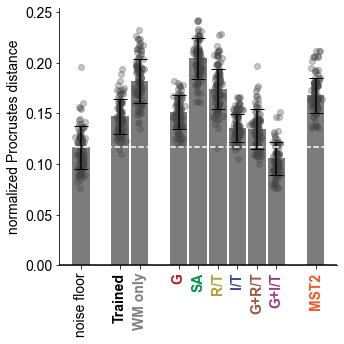

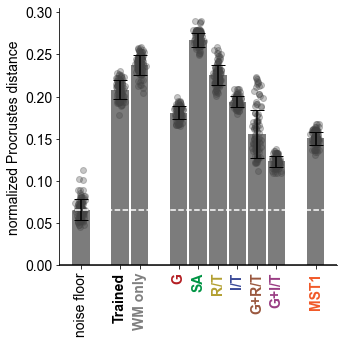

In [205]:
save_figure=True
calculate_model_distances_to_neural(neuraldata_name="mendoza_halliday_et_al_2014", save_figure=save_figure)
calculate_model_distances_to_neural(neuraldata_name="mendoza_halliday_et_al_2023", save_figure=save_figure)